## Clasificar objetos segmentados de una imagen aérea

En este notebook se ve como, dada una colección de objetos segmentados en vista aérea, se puede entrenar una CNN (Convolutional Neural Network) para clasificar cada objeto según su tipo.

In [2]:
# Importar librerías
import pandas as pd
import PIL as pil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow.math as tfmath
from math import *
import time
%config Completer.use_jedi = False

In [3]:
# Verificar que Tensorflow reconoce la GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4746662657945711658
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10488053760
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12757354336426039878
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Cargar el data set

En primer lugar debe cargarse el dataset (conjunto de datos) y dividirse en 2 subconjuntos, el de entrenamiento y el de prueba. Además, el conjunto de entrenamiento se dividirá a su vez en otros dos subconjuntos, el de entrenamiento propiamente dicho y el de validación, que se usará durante el entrenamiento para analizar la evolución del aprendizaje.

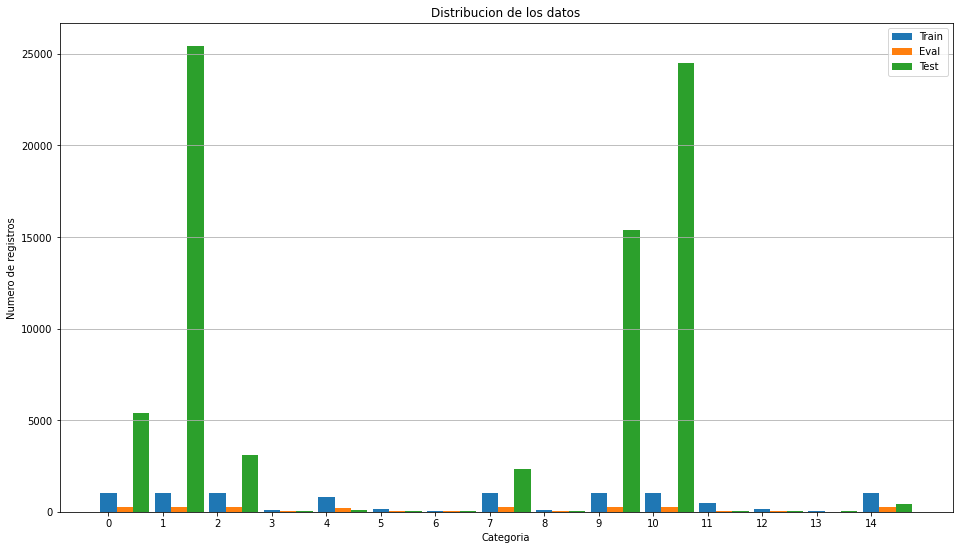

In [4]:
# Función para traducir una etiqueta textual a su número entero correspondiente
def label_to_int(lbl):
    if lbl == 'plane' : return 0
    if lbl == 'ship' : return 1
    if lbl == 'storage-tank' : return 2
    if lbl == 'baseball-diamond' : return 3
    if lbl == 'tennis-court' : return 4
    if lbl == 'basketball-court' : return 5
    if lbl == 'ground-track-field' : return 6
    if lbl == 'harbor' : return 7
    if lbl == 'bridge' : return 8
    if lbl == 'large-vehicle' : return 9
    if lbl == 'small-vehicle' : return 10
    if lbl == 'helicopter' : return 11
    if lbl == 'roundabout' : return 12
    if lbl == 'soccer-ball-field' : return 13
    if lbl == 'swimming-pool' : return 14
    raise Exception('Unexpected label exception')

# Especificación de como se desean distribuir los datos disponibles
total_cases = np.array([6620, 26675, 4336, 142, 1101, 235,  93, 3610, 176, 16640, 25759, 613, 197, 112, 1697])
train_cases = np.array([1000,  1000, 1000, 100,  800, 150,  50, 1000, 100,  1000,  1000, 500, 128,  50, 1000])
eval_cases = np.array( [ 250,   250,  250,  20,  200,  50,  20,  250,  20,   250,   250,  50,  32,  16,  250])
test_cases = total_cases - train_cases - eval_cases

# Cargar mapa de datos
data = pd.read_csv(
    '/smalldata/phd/AerialImagesCNN/datasets/dota1_0/cnn_data/gt.csv',
    header=None,
    delimiter=','
)

# Mezclar datos aleatoriamente
int_labels = np.vectorize(label_to_int)(data.iloc[:, 0].to_numpy())
path_images = data.iloc[:, 1].to_numpy()
indices = [i for i in range(int_labels.shape[0])]
np.random.shuffle(indices)
int_labels = int_labels[indices]
path_images = path_images[indices]

# Mostrar distribucion de los datos
plt.figure(figsize=(16, 9))
T = np.array([i for i in range(15)])
plt.title('Distribucion de los datos')
plt.bar(T, train_cases, width=0.3, label='Train')
plt.bar(T+0.3, eval_cases, width=0.3, label='Eval')
plt.bar(T+0.6, test_cases, width=0.3, label='Test')
plt.grid(axis='y')
plt.ylabel('Numero de registros')
plt.xlabel('Categoria')
plt.xticks(T)
plt.legend()
plt.show()

In [5]:
# Función para cargar los datos de entrenamiento y validacion
def load_train_and_validation(int_labels, path_images, train_cases, eval_cases):
    # Inicializar listas y contadores
    n_classes     = train_cases.shape[0]
    n_train_cases = np.sum(train_cases)
    n_eval_cases  = np.sum(eval_cases)
    count_train   = 0
    count_eval    = 0
    train_labels  = []
    train_images  = []
    eval_labels   = []
    eval_images   = []
    current_train = [0 for n in range(n_classes)]
    current_eval  = [0 for n in range(n_classes)]
    
    # Poblar listas
    for i, int_label in enumerate(int_labels):
        if current_train[int_label] < train_cases[int_label]:  # Añadir a entrenamiento
            train_labels.append(int_label)
            train_images.append(np.array(pil.Image.open(path_images[i])))
            
            # Actualizar contadores de entrenamiento
            current_train[int_label] += 1
            count_train += 1
            continue
            
        elif current_eval[int_label] < eval_cases[int_label]:  # Añadir a validacion
            eval_labels.append(int_label)
            eval_images.append(np.array(pil.Image.open(path_images[i])))
            
            # Actualizar contadores de evaluacion
            current_eval[int_label] += 1
            count_eval += 1
            continue
        
        # Evitar iteraciones ociosas
        if count_train == n_train_cases and count_eval == n_eval_cases:
            break
            
    # Devolver los datos
    return i, np.array(train_labels), np.array(train_images), np.array(eval_labels), np.array(eval_images)
        
    
# Cargar data sets de entrenamiento y validacion
start = time.perf_counter()
test_start_index, train_labels, train_images, eval_labels, eval_images = load_train_and_validation(
    int_labels, path_images, train_cases, eval_cases
)
end = time.perf_counter()

print(f'Datos cargados en {end-start}')
print('Train size: ', train_labels.shape)
print('Eval size: ', eval_labels.shape)

Datos cargados en 465.742179717985
Train size:  (8878,)
Eval size:  (2158,)


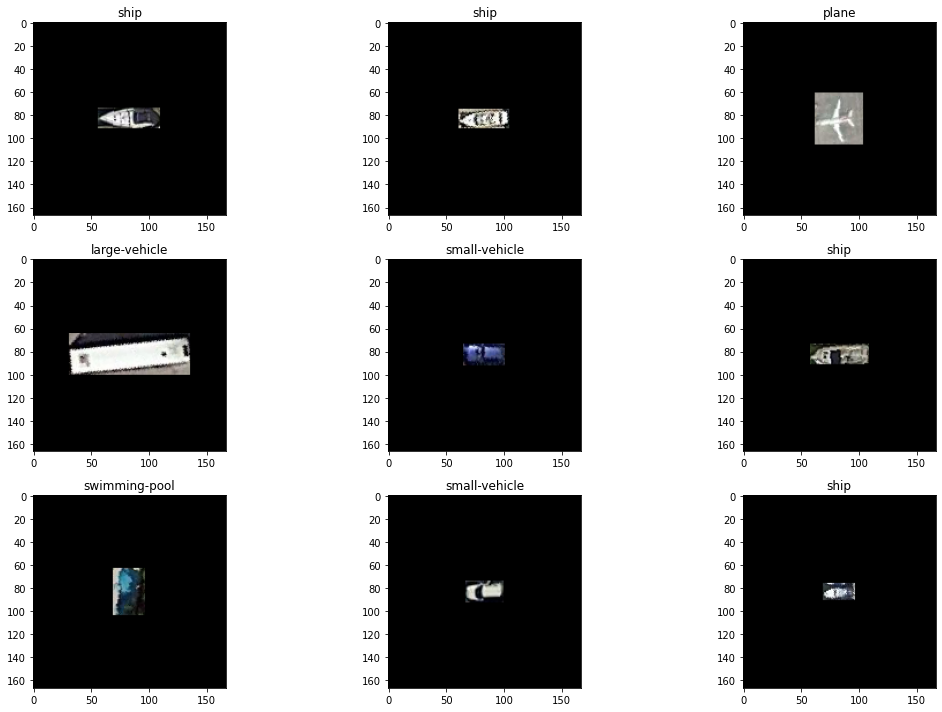

In [6]:
# Función para traducir una etiqueta textual a su número entero correspondiente
def int_to_label(lbl):
    if lbl == 0  : return 'plane'
    if lbl == 1  : return 'ship'
    if lbl == 2  : return 'storage-tank'
    if lbl == 3  : return 'baseball-diamond'
    if lbl == 4  : return 'tennis-court'
    if lbl == 5  : return 'basketball-court'
    if lbl == 6  : return 'ground-track-field'
    if lbl == 7  : return 'harbor'
    if lbl == 8  : return 'bridge'
    if lbl == 9  : return 'large-vehicle'
    if lbl == 10 : return 'small-vehicle'
    if lbl == 11 : return 'helicopter'
    if lbl == 12 : return 'roundabout'
    if lbl == 13 : return 'soccer-ball-field'
    if lbl == 14 : return 'swimming-pool'
    raise Exception('Unexpected label exception')

# Función para mostrar imágenes con texto
def imgplot(I, L, grid=[3, 3]):
    plt.figure(figsize=(16,10))
    for i, img in enumerate(I):
        ax = plt.subplot(grid[0], grid[1], i+1)
        plt.title(int_to_label(L[i]))
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
# Mostrar imágenes cargadas
imgplot(train_images[:9], train_labels[:9], grid=[3,3])

# Preparar datos I
Seleccionar aquellos datos del conjunto original que se consideren de interés para la clasificación. En este caso, se filtran por clase, de manera que se descartan aquellas clases que no resulten de interés para la clasificación.

In [7]:
to_remove = [  # Vector que especifica que categorías eliminar (True) y cuales no (False)
    False, False, False, True, False, True, True, True, True, False, True, True, True, True, False 
]

# Averiguar que registros se deben eliminar por ser de una categoría descartada
train_remove = []
eval_remove = []
for i, lbl in enumerate(train_labels):
    if to_remove[lbl]:
        train_remove.append(i)
for i, lbl in enumerate(eval_labels):
    if to_remove[lbl]:
        eval_remove.append(i)
        
# Eliminar los registros oportunos
train_images = np.delete(train_images, train_remove, axis=0)
train_labels = np.delete(train_labels, train_remove, axis=0)
eval_images = np.delete(eval_images, eval_remove, axis=0)
eval_labels = np.delete(eval_labels, eval_remove, axis=0)

# Componer diccionario para traducir categorías
shifted_labels = np.sort(np.unique(train_labels))
clean_labels = [i for i in range(shifted_labels.shape[0])]
labels_dict = {}
for i in range(shifted_labels.shape[0]):
    labels_dict[shifted_labels[i]] = clean_labels[i]
    
# Traducir las categorías viejas para que las nuevas sean secuenciales, ordenadas y con diferencia unitaria
for i, lbl in enumerate(train_labels):
    train_labels[i] = labels_dict[lbl]
for i, lbl in enumerate(eval_labels):
    eval_labels[i] = labels_dict[lbl]

# Numero de categorías tras eliminar
num_clean_classes = np.count_nonzero(np.array(to_remove) == False)
print(f'El numero de clases tras la limpieza es de {num_clean_classes}')
print(f'El numero de imagenes de entrenamiento tras la limpieza es de {train_images.shape[0]}')
print(f'El numero de imagenes de evaluacion tras la limpieza es de {eval_images.shape[0]}')

El numero de clases tras la limpieza es de 6
El numero de imagenes de entrenamiento tras la limpieza es de 5800
El numero de imagenes de evaluacion tras la limpieza es de 1450


## Preparar datos II

Simplemente se normalizan los valores RGB al intervalo $[0, 1]$ y se aplica one hot encoding a las etiquetas.

Imagenes normalizadas en 3.069255853013601 segundos


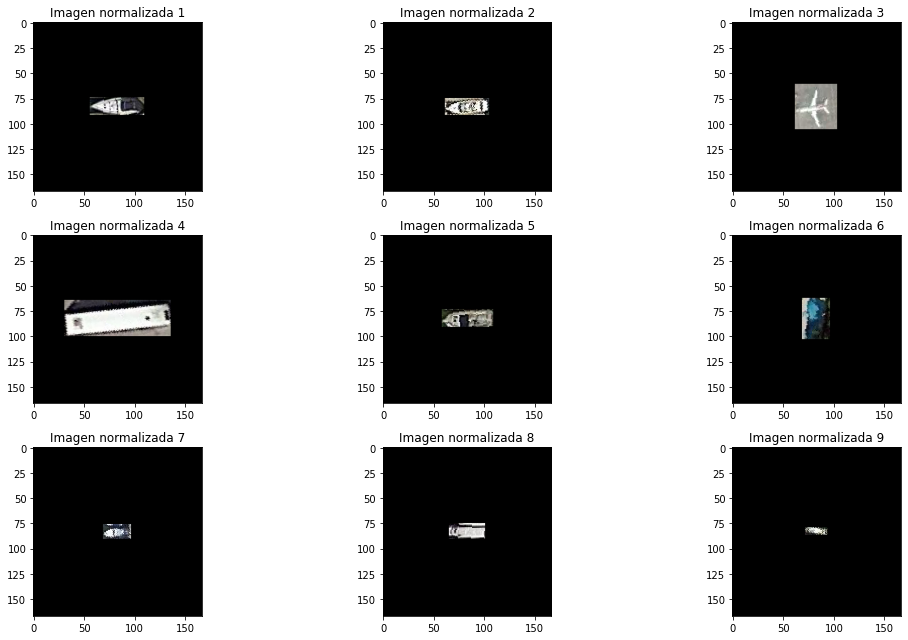

In [8]:
# Normalizar
start = time.perf_counter()
train_images = train_images.astype(float)
eval_images = eval_images.astype(float)
image_max = max(np.max(train_images), np.max(eval_images))
for i in range(train_images.shape[0]):  # En bucle porque no hay memoria suficiente para hacerlo de golpe
    train_images[i] = train_images[i].astype(float) / image_max
for i in range(eval_images.shape[0]):  # En bucle porque no hay memoria suficiente para hacerlo de golpe
    eval_images[i] = eval_images[i].astype(float) / image_max
end = time.perf_counter()
print(f'Imagenes normalizadas en {end-start} segundos')

# Aplicar one-hot-encoding a las categorías
train_Y = keras.utils.to_categorical(train_labels, num_clean_classes)
eval_Y = keras.utils.to_categorical(eval_labels, num_clean_classes)

# Mostrar imágenes normalizadas
plt.figure(figsize=(16, 9))
for i, img in enumerate(train_images[:9]):
    ax = plt.subplot(3, 3, i+1)
    plt.title(f'Imagen normalizada {i+1}')
    ax.imshow(img)
plt.tight_layout()
plt.show()

## Red neuronal convolucional : Entrenamiento

Entrenamiento de una red neuronal convolucional que clasifica las imágenes dadas según el objeto que aparezca en ellas.

In [9]:
# Inicializar modelo
model = keras.models.Sequential()

# Añadir capa de entrada (Input Layer)
model.add(keras.layers.Input(train_images[0].shape))

# ---  Bloque 1  --- #
# ------------------ #
model.add(keras.layers.Conv2D(  # Primera capa convolucional del bloque 1
    64,  # Dimensionalidad de la salida
    kernel_size=(3, 3),  # Tamaño de ventana
    strides=(2, 2),  # Paso de la convolución
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    activation='relu',  # Función de activación (Rectified Linear Unit)
    name='bloque1_convolucion1'  # Nombre de la capa
))
model.add(keras.layers.Conv2D(  # Segunda capa convolucional del bloque 1
    128,  # Dimensionalidad de la salida
    kernel_size=(3, 3),  # Tamaño de ventana
    strides=(2, 2),  # Paso de la convolución
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    activation='relu',  # Función de activación (Rectified Linear Unit)
    name='bloque1_convolucion2'  # Nombre de la capa
))
model.add(keras.layers.MaxPooling2D(
    pool_size=(2, 2),  # Tamaño de ventana
    strides=(1, 1),    # Paso del pooling
    padding='same',     # Padding (same implica que se aplique por igual a cada lado)
    name='bloque1_pooling'  # Nombre de la capa
))

# ---  Bloque 2  --- #
# ------------------ #
model.add(keras.layers.Conv2D(  # Primera capa convolucional del bloque 2
    128,
    kernel_size=(3, 3),  # Tamaño de ventana
    strides=(2, 2),  # Paso de la convolución
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    name='bloque2_convolucion1'  # Nombre de la capa
))
model.add(keras.layers.Conv2D(  # Primera capa convolucional del bloque 2
    256,
    kernel_size=(3, 3),  # Tamaño de ventana
    strides=(2, 2),  # Paso de la convolución
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    name='bloque2_convolucion2'  # Nombre de la capa
))
model.add(keras.layers.MaxPooling2D(
    pool_size=(2, 2),  # Tamaño de ventana
    strides=(1, 1),    # Paso del pooling
    padding='same',     # Padding (same implica que se aplique por igual a cada lado)
    name='bloque2_pooling'  # Nombre de la capa
))

# ---  Bloque 3  --- #
# ------------------ #
model.add(keras.layers.Conv2D(  # Primera capa convolucional del bloque 2
    256,
    kernel_size=(3, 3),  # Tamaño de ventana
    strides=(2, 2),  # Paso de la convolución
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    name='bloque3_convolucion1'  # Nombre de la capa
))
model.add(keras.layers.Conv2D(  # Primera capa convolucional del bloque 2
    512,
    kernel_size=(3, 3),  # Tamaño de ventana
    strides=(2, 2),  # Paso de la convolución
    padding='same',  # Padding (same implica que se aplique por igual a cada lado)
    name='bloque3_convolucion2'  # Nombre de la capa
))
model.add(keras.layers.MaxPooling2D(
    pool_size=(2, 2),  # Tamaño de ventana
    strides=(1, 1),    # Paso del pooling
    padding='same',     # Padding (same implica que se aplique por igual a cada lado)
    name='bloque3_pooling'  # Nombre de la capa
))


# ---  Bloque final  --- #
# ---------------------- #
model.add(keras.layers.Flatten())  # Capa de aplanamiento
model.add(keras.layers.Dense(256, activation='relu', name='FF1'))  # Capa densa clásica
model.add(keras.layers.BatchNormalization())  # Estandarización que tiende a media 0 y desviación típica 1
model.add(keras.layers.Dropout(0.5)) # Capa de dropout (activation/desactivación pseudoaleatoria)
model.add(keras.layers.Dense(256, activation='relu', name='FF2'))  # Capa densa clásica
model.add(keras.layers.BatchNormalization())  # Estandarización que tiende a media 0 y desviación típica 1
model.add(keras.layers.Dropout(0.5))  # Capa de dropout (activation/desactivación pseudoaleatoria)
model.add(keras.layers.Dense(  # Capa densa clásica de salida
    num_clean_classes,
    activation='softmax',
    name='Predicciones'
))



# Mostrar un resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bloque1_convolucion1 (Conv2D (None, 84, 84, 64)        1792      
_________________________________________________________________
bloque1_convolucion2 (Conv2D (None, 42, 42, 128)       73856     
_________________________________________________________________
bloque1_pooling (MaxPooling2 (None, 42, 42, 128)       0         
_________________________________________________________________
bloque2_convolucion1 (Conv2D (None, 21, 21, 128)       147584    
_________________________________________________________________
bloque2_convolucion2 (Conv2D (None, 11, 11, 256)       295168    
_________________________________________________________________
bloque2_pooling (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
bloque3_convolucion1 (Conv2D (None, 6, 6, 256)         5

In [10]:
# Configurar optimizador
optimizer = keras.optimizers.Adam(lr=0.0001)

# Configurar callback de early-stopping para evitar seguir entrenando cuando no se consiga mejorar
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Compilar el modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Entrenar la red neuronal profunda
n_epochs=32
history = model.fit(
    train_images,     # Datos de entrenamiento
    train_Y,          # Clases de entrenamiento (Ground truth)
    batch_size=32,    # Tamaño de lote
    epochs=n_epochs,  # Épocas de entrenamiento
    verbose=1,        # Reportar el entrenamiento conforme se realiza
    validation_data=(eval_images, eval_Y),  # Datos y clases para validar el entrenamiento
    callbacks=[early_stopping]  # Callbacks
)

Epoch 1/32
182/182 [==============================] - 21s 32ms/step - loss: 1.5262 - accuracy: 0.5143 - val_loss: 1.5646 - val_accuracy: 0.2007
Epoch 2/32
182/182 [==============================] - 4s 24ms/step - loss: 0.6306 - accuracy: 0.7806 - val_loss: 0.8861 - val_accuracy: 0.7931
Epoch 3/32
182/182 [==============================] - 4s 24ms/step - loss: 0.4711 - accuracy: 0.8415 - val_loss: 0.4237 - val_accuracy: 0.9014
Epoch 4/32
182/182 [==============================] - 4s 24ms/step - loss: 0.3116 - accuracy: 0.9010 - val_loss: 0.2903 - val_accuracy: 0.8986
Epoch 5/32
182/182 [==============================] - 4s 24ms/step - loss: 0.2672 - accuracy: 0.9119 - val_loss: 0.1851 - val_accuracy: 0.9407
Epoch 6/32
182/182 [==============================] - 4s 24ms/step - loss: 0.2279 - accuracy: 0.9244 - val_loss: 0.2565 - val_accuracy: 0.9241
Epoch 7/32
182/182 [==============================] - 4s 24ms/step - loss: 0.1491 - accuracy: 0.9497 - val_loss: 0.1838 - val_accuracy: 0.944

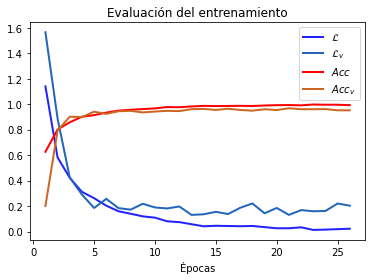

In [11]:
# Gráfico de pérdida y accuracy
T = np.arange(1, len(history.history['loss'])+1, 1)
plt.plot(T, history.history['loss'], label='$\mathcal{L}$', color='#2222FF', lw=2)
plt.plot(T, history.history['val_loss'], label='$\mathcal{L}_{v}$', color='#2266BB', lw=2)
plt.plot(T, history.history['accuracy'], label='$Acc$', color='#FF0000', lw=2)
plt.plot(T, history.history['val_accuracy'], label='$Acc_{v}$', color='#CC6622', lw=2)
plt.title('Evaluación del entrenamiento')
plt.xlabel('Épocas')
plt.legend(loc='best')
plt.show()

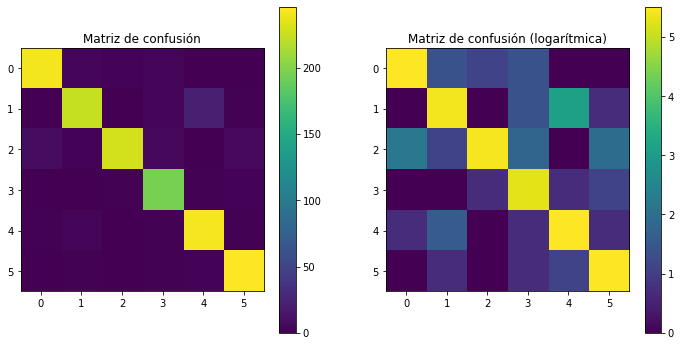

In [12]:
# Obtener la clasificación del modelo con respecto de los datos de validación
expe = eval_Y.argmax(axis=1)  # Argmax para tomar el mayor valor como la clase real
pred = model.predict(eval_images).argmax(axis=1)  # Argmax para tomar el mayor valor tras aplicar softmax

# Obtener la matriz de confusión
cm = tfmath.confusion_matrix(expe, pred)

# Representación gráfica de la matriz de confusión
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)  # Gráfico izquierdo
mat1 = ax1.imshow(cm)
fig.colorbar(mat1, ax=ax1)
ax1.set_title('Matriz de confusión')

# Representación gráfica de la matriz de confusión en escala logarítmica
ax2 = fig.add_subplot(1, 2, 2)  # Gráfico derecho
mat2 = ax2.imshow(np.log(cm+1))
fig.colorbar(mat2, ax=ax2)
ax2.set_title('Matriz de confusión (logarítmica)')

# Mostrar gráficos
plt.show()

## Red neuronal convolucional : Clasificación

Ahora toca usar la red neuronal ya entrenada para clasificar los datos.

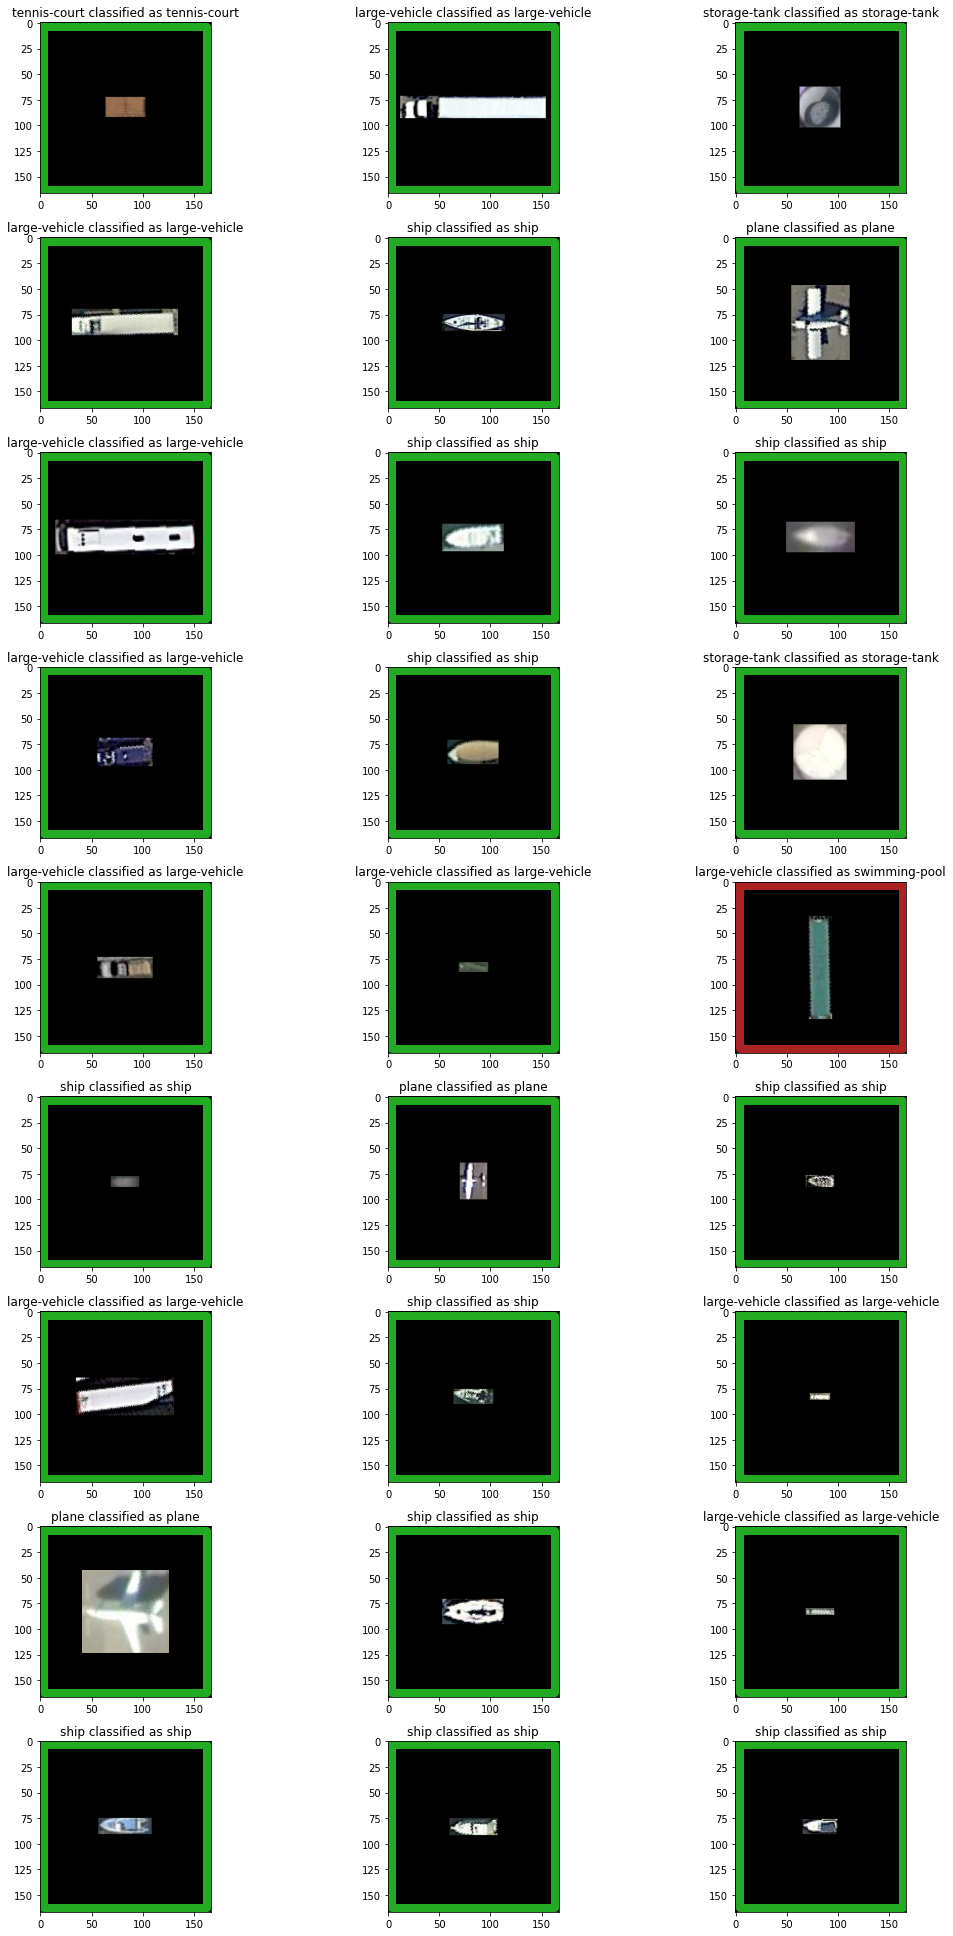

In [13]:
# Iterador funcional sobre los datos a clasificar
def build_dataset_iterator(int_labels, path_images, to_remove, image_max=255.0, cases_per_call=24):
    # Inicializar listas y contadores
    labels        = []
    images        = []
    cases_count   = 0
    
    # Poblar listas
    for i, int_label in enumerate(int_labels):
        if to_remove[int_label]:  # Ignorar clases no consideradas por el clasificador
            continue
        # Considerar label y la imagen ya normalizada
        labels.append(int_label)  
        images.append(np.clip(np.array(pil.Image.open(path_images[i])).astype(float) / image_max, 0.0, 1.0))
        
        # Actualizar contador de casos
        cases_count += 1
        
        # Evitar superar el número de casos por llamada
        if cases_count == cases_per_call:
            yield_labels = labels
            yield_images = images
            labels       = []
            images       = []
            cases_count  = 0
            yield yield_labels, yield_images
            

# Función que clasifica el dataset dado
def classify_dataset(X, model):
    return model.predict(np.array(X)).argmax(axis=1)  # Argmax para tomar el mayor valor en vector softmax
    
# Función que imprime el resultado de una clasificación dada
def plot_classification(X, prediction, expectation, reverse_dict):
    n = len(X)
    cols = 3
    rows = int(n/cols)
    img_dim = X[0].shape[:2]
    frame_width = 8
    img_frame = np.array([
        [frame_width/2, frame_width/2],
        [frame_width/2, img_dim[1]-frame_width/2],
        [img_dim[0]-frame_width/2, img_dim[1]-frame_width/2],
        [img_dim[0]-frame_width/2, frame_width/2],
        [frame_width/2, frame_width/2]
    ])
    
    plt.figure(figsize=(16, rows*3))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        expected_label = expectation[i]
        expected_class = int_to_label(expected_label)
        predicted_label = reverse_dict[prediction[i]]
        predicted_class = int_to_label(predicted_label)
        plt.title(f"{expected_class} classified as {predicted_class}")
        ax.imshow(X[i])
        color = '#FF3333'
        if predicted_label == expected_label:
            color = '#33FF33'
        ax.plot(img_frame[:, 0], img_frame[:, 1], lw=frame_width, color=color, alpha=0.67)
    plt.tight_layout()
    plt.show()
    

# Preparar la clasificación
test_int_labels  = int_labels[test_start_index:]  # Vector de etiquetas empezando en el conjunto de prueba
test_path_images = path_images[test_start_index:]  # Vector de imágenes empezando en el conjunto de prueba
accepted_labels  = list(labels_dict.keys())  # Qué etiquetas se están considerando para la clasificación
reverse_dict = {v: k for k, v in labels_dict.items()} # Diccionario inverso para traducir clasificaciones
dataset_iterator = build_dataset_iterator(  # Construir iterador de datos
    test_int_labels,
    test_path_images,
    to_remove,
    image_max,
    27
)

# Iterar los datos, empezando a partir de los ya considerados para entrenar y validar
test_expectation, test_image = next(dataset_iterator)  # Obtener siguiente bloque de datos
prediction = classify_dataset(test_image, model)  # Clasificar bloque de datos
plot_classification(test_image, prediction, test_expectation, reverse_dict)  # Mostrar clasificación

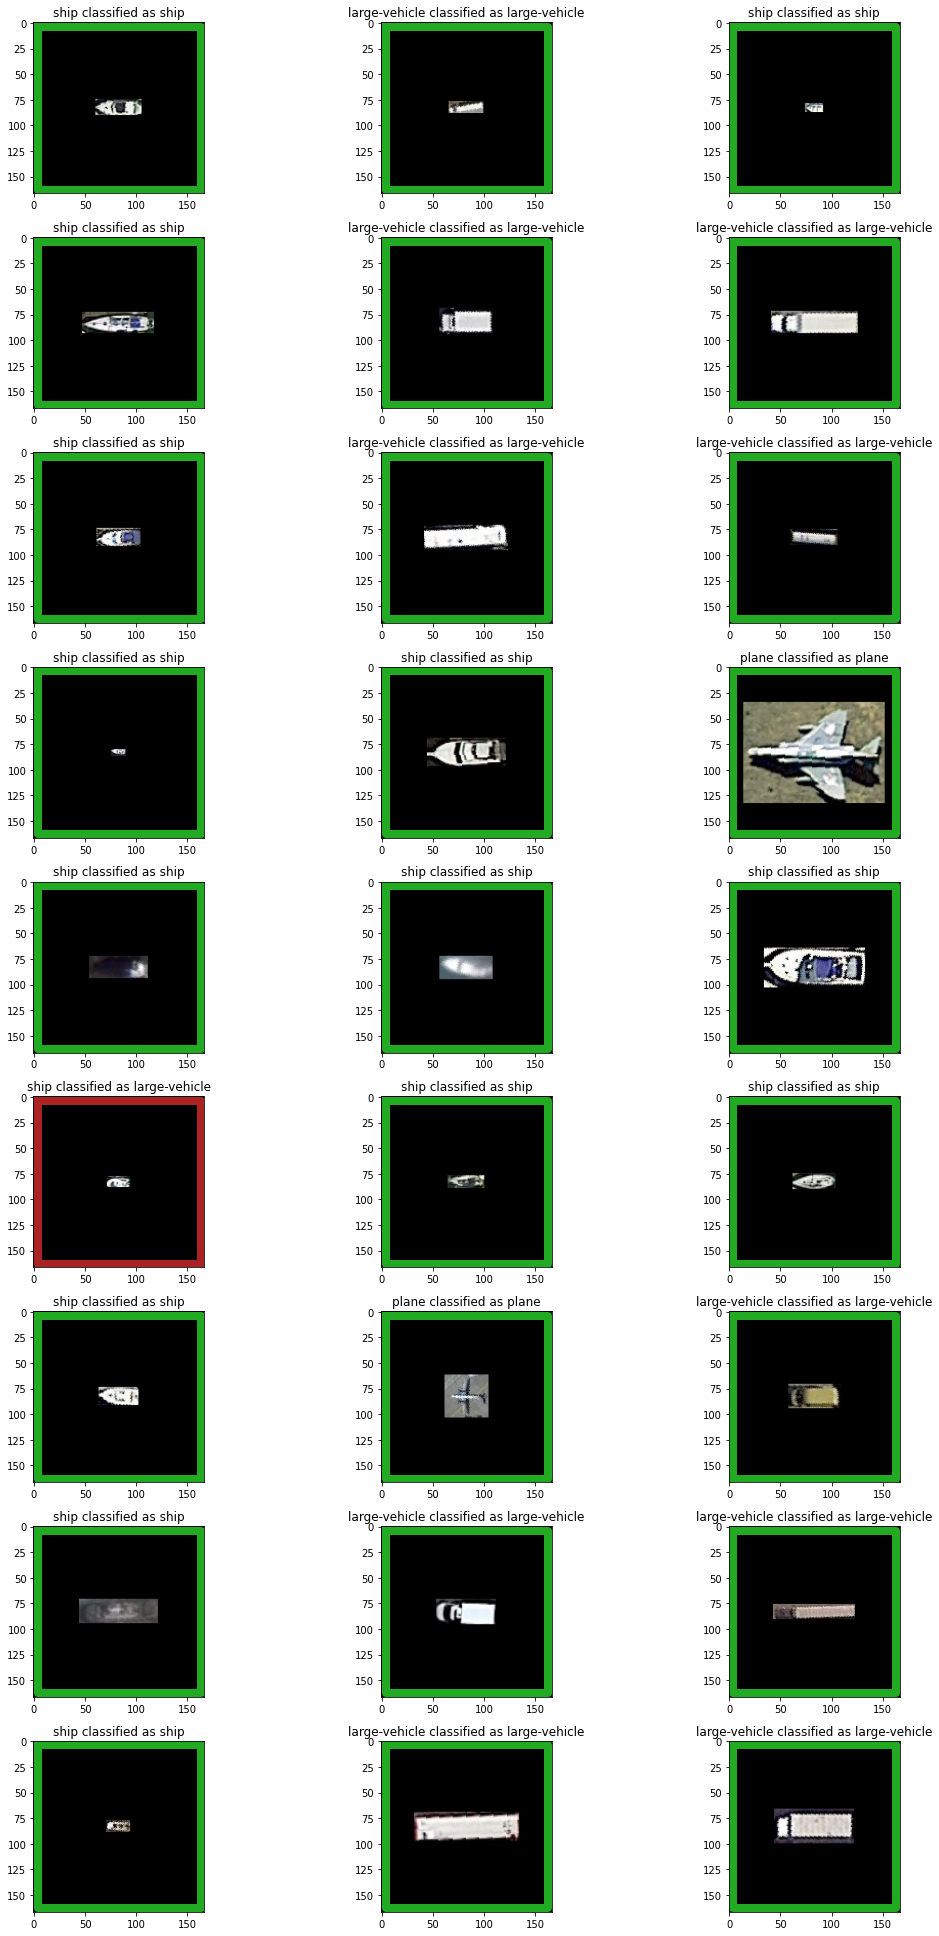

In [14]:
# Más clasificaciones
test_expectation, test_image = next(dataset_iterator) 
prediction = classify_dataset(test_image, model)
plot_classification(test_image, prediction, test_expectation, reverse_dict)

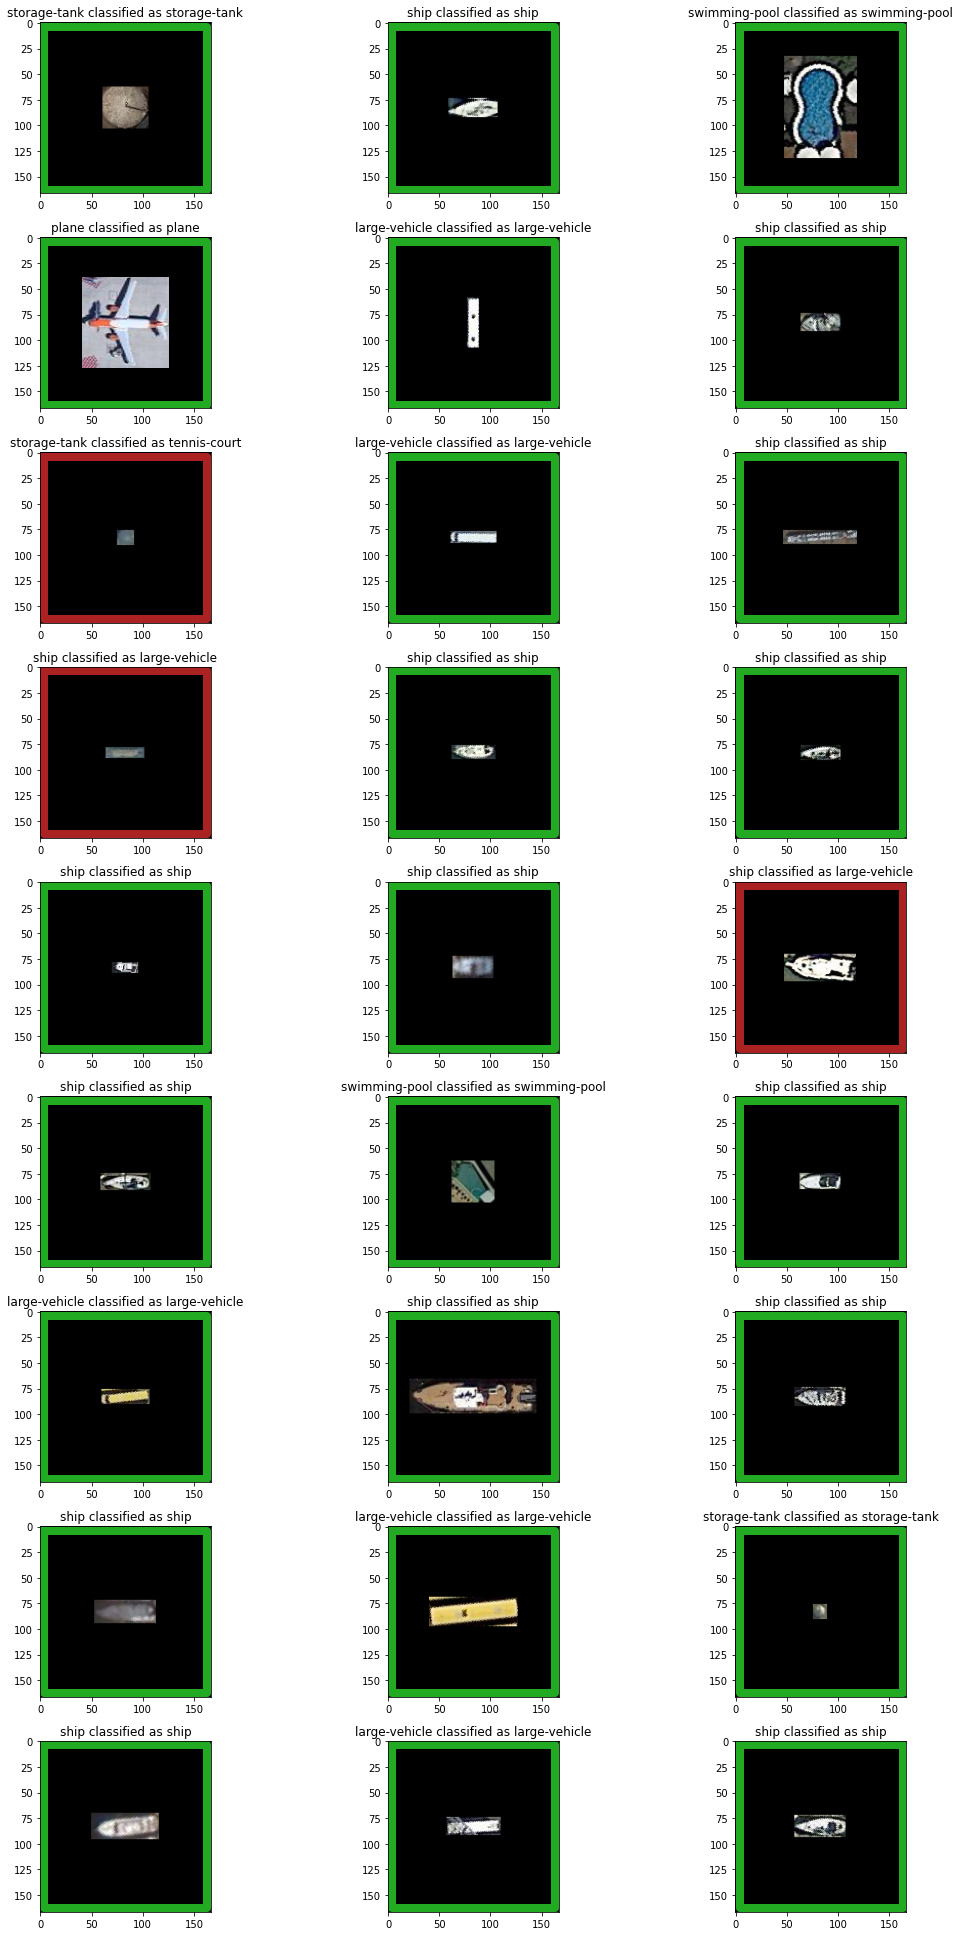

In [15]:
# Todavía más clasificaciones
test_expectation, test_image = next(dataset_iterator) 
prediction = classify_dataset(test_image, model)
plot_classification(test_image, prediction, test_expectation, reverse_dict)

In [574]:
# En caso de querer más clasificaciones, descomentar el código de abajo y copiarlo y pegarlo para
# continuar clasificando hasta agotar el dataset

#test_dataset = next(next_dataset(int_labels[test_start_index:], path_images[test_start_index:], 24))
#prediction = classify_dataset(test_dataset[1], model, image_max)
#plot_classification(test_dataset[1], test_dataset[0], expectation)